In [287]:
#Importing the Necessary libraries

import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn


In [288]:
# Defining the transform object to convert the MNIST dataset images to a float tensor 
transform = transforms.Compose(
        [transforms.ToTensor()])
# Loading the train and test datasets and their loader objects with a batch size of 10
dataset_train = datasets.MNIST("data", train=True, download=True, transform=transform)
dataset_test = datasets.MNIST("data", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32)

In [296]:
# Creating the Neural Network 
'''
Construct a ReLU-activated neural network with four hidden layers with sizes [1000, 1000, 500, 200].

'''

def neural_net():
    Model = nn.Sequential(
            nn.Linear(28*28, 1000,bias=False),nn.ReLU(),
            nn.Linear(1000, 1000,bias=False),nn.ReLU(),
            nn.Linear(1000, 500,bias=False),nn.ReLU(),
            nn.Linear(500, 200,bias=False),nn.ReLU(),
            nn.Linear(200,10,bias=False))
    
    print(Model)

    return Model


In [297]:
model = neural_net()

Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=False)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=False)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=500, bias=False)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=200, bias=False)
  (7): ReLU()
  (8): Linear(in_features=200, out_features=10, bias=False)
)


In [ ]:
# Training the model using Adam Optimizer and the loss function used is Cross Entropy Loss


def train(model, train_loader,epoch):
    model.train()
    
    for index,(data, labels) in enumerate(train_loader):    #Training Process started
        optimizer = optim.Adam(model.parameters(),lr=0.1)        #Learning Rate =0.1
        optimizer.zero_grad()                                   #Setting the gradients to 0
        #labels = labels.to(device)
        output = model(data.view(32, -1))                      #Forward Pass
        loss = nn.CrossEntropyLoss()                           #Loss function initialization
        l = loss(output,labels)
        l.backward()
        optimizer.step()
        if index % 1000 == 0:                                 #Calculating the loss for each epoch
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    index * len(data),
                    len(train_loader.dataset),
                    100.0 * index / len(train_loader),
                    l.item(),
                )
            )

            
num_epochs = 25
for epoch in range(1, num_epochs + 1):
    train(model, train_loader,epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 7 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 8 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 9 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.302585
Train Epoch: 10 [32000/60000 (53%)]	Loss: 2.302585
Train Epoch: 11 [0/60000 (0%)]	Loss: 2.302585
Tr

In [294]:
#Saving the model trained for 25 epochs
torch.save(model.state_dict(), "bittensor_trained_model.pth")

In [295]:
#Getting the Test Accuracies and Loss before pruning the weights (Pre-Pruning)

import numpy as np
def test(model, test_loader):
    model.eval()
    test_loss = 0
    loss = nn.CrossEntropyLoss()
    correct = 0
    total = list(0. for i in range(10))

    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data.view(data.shape[0],-1))
            predicted = torch.max(output.data, axis=1)[1]          #Converting the probabilities to predicted class
            test_loss += loss(output, labels)
            correct += (predicted == labels).sum()                #Counting the no. of correct predictions
    avg_test_loss = test_loss/len(test_loader.dataset)
    #avg_test_acc = (correct/len(test_loader.dataset)).numpy()
    print(
        "\nTest set: Average loss:",str(avg_test_loss)
        )
    accuracy = float(100. * (correct/dataset_test.data.shape[0]))
    #print("Test Accuracy = ",accuracy)    
    return accuracy   

test_acc = test(model, test_loader)  #Calculating the Test loss and Test Accuracy before pruning


Test set: Average loss: tensor(0.0721)
Test Accuracy =  9.800000190734863


In [277]:
k_percentage = [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]
accuracy_weight = []
accuracy_unit = []

## WEIGHT PRUNING

In [278]:
def weight_pruning(k):
    model = neural_net()
    model.load_state_dict(torch.load('bittensor_trained_model.pth'))
    layers = list(model.state_dict())
    layer_weights = {}
    pruned_weights =[]
    weights = model.state_dict()
    for l in layers[:-1]:
        a = weights[l]
        w = np.array(a)
        layer_weights[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)
        threshold_val = np.ceil(np.max(layer_weights[l]) * k).astype(int)
        layer_weights[l][layer_weights[l] <= threshold_val] = 0                  # 0 below threshold
        layer_weights[l][layer_weights[l] > threshold_val] = 1                   # 1 above threshold
#         if layer_weights[l].any() <= threshold_val:
#             layer_weights[l] = 0
#         if layer_weights[l].any() > threshold_val:
#             layer_weights[l] = 0    
        w = w * layer_weights[l]
        a[...] = torch.from_numpy(w)
        pruned_weights.append(data)
    
    pruned_weights.append(weights[layers[-1]])                      # Append the output layer weights

    pruned_state_dict = OrderedDict()                                  # Store and update the weights
    for i, w in zip(layers, pruned_weights):
        pruned_state_dict[i] = w
        
    model.state_dict = pruned_state_dict
    accuracy_weight.append(test(model, test_loader))

## UNIT PRUNING

In [279]:
from numpy import linalg
def unit_pruning(k):
    model = neural_net()
    model.load_state_dict(torch.load('bittensor_trained_model.pth'))
    layers = list(model.state_dict())
    layer_weights = {}
    pruned_weights =[]
    weights = model.state_dict()
    for l in layers[:-1]:
        a = weights[l]
        w = np.array(a)
        norm = linalg.norm(w, axis=0)                       
        norm = np.tile(norm, (w.shape[0],1))            
        layer_weights[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)
        threshold_val = np.ceil(np.max(layer_weights[l]) * k).astype(int)
        layer_weights[l][layer_weights[l] <= threshold_val] = 0                  # 0 below threshold
        layer_weights[l][layer_weights[l] > threshold_val] = 1                   # 1 above threshold
#         if layer_weights[l].any() <= threshold_val:
#             layer_weights[l] = 0
#         if layer_weights[l].any() > threshold_val:
#             layer_weights[l] = 0    
        w = w * layer_weights[l]
        a[...] = torch.from_numpy(w)
        pruned_weights.append(data)
    
    pruned_weights.append(weights[layers[-1]])                      # Append the output layer weights

    pruned_state_dict = OrderedDict()                                  # Store and update the weights
    for i, w in zip(layers, pruned_weights):
        pruned_state_dict[i] = w
        
    model.state_dict = pruned_state_dict
    accuracy_unit.append(test(model, test_loader))

In [280]:
for k in k_percentage:
    weight_pruning(k)
    unit_pruning(k)

Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=False)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=False)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=500, bias=False)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=200, bias=False)
  (7): ReLU()
  (8): Linear(in_features=200, out_features=10, bias=False)
)

Test set: Average loss: tensor(0.0682)
Test Accuracy =  36.70000076293945
Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=False)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=False)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=500, bias=False)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=200, bias=False)
  (7): ReLU()
  (8): Linear(in_features=200, out_features=10, bias=False)
)

Test set: Average loss: tensor(0.0682)
Test Accuracy =  36.70000076293945
Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=False)
  (1): ReLU()
  (2):

In [281]:
print("Accuracy WEIGHT = ",accuracy_weight)
print("Accuracy UNIT = ",accuracy_unit)

Accuracy WEIGHT =  [36.70000076293945, 36.70000076293945, 36.70000076293945, 36.70000076293945, 36.689998626708984, 36.5099983215332, 34.45000076293945, 35.540000915527344, 36.65999984741211, 36.7599983215332]
Accuracy UNIT =  [36.70000076293945, 36.70000076293945, 36.70000076293945, 36.70000076293945, 36.689998626708984, 36.5099983215332, 34.45000076293945, 35.540000915527344, 36.65999984741211, 36.7599983215332]


## PLOTTING THE GRAPHS 

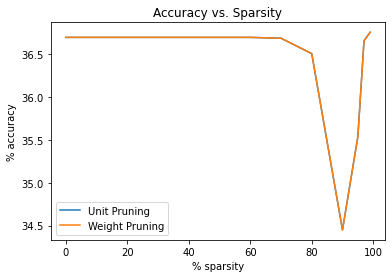

In [286]:
import matplotlib.pyplot as plt

k = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
plt.title('Accuracy vs. Sparsity')
plt.plot(k, accuracy_unit, label='Unit Pruning')
plt.plot(k, accuracy_weight, label='Weight Pruning')
plt.legend(loc='best')
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
plt.show()

# ANALYSIS

### 1. What interesting insights did you find?

### 2. Do the curves differ? Why do you think that is/isn’t?

### 3.  Do you have any hypotheses as to why we are able to delete so much of the network without hurting performance 